In [78]:
import numpy as np
import tensorflow as tf
from tensorflow import set_random_seed
from tensorflow import keras
from tensorflow.keras import layers
from keras import backend as K
import matplotlib.pyplot as plt

seed_value= 0

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
tf.random.set_seed(seed_value)
# for later versions: 
# tf.compat.v1.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

ImportError: cannot import name 'set_random_seed' from 'tensorflow' (/home/diogo/Projects/learning/keras001/.venv/lib/python3.8/site-packages/tensorflow/__init__.py)

In [2]:
def view_images(dataset, size):
    images, labels = dataset
    assert images.shape[0] == labels.shape[0]

    num_images = images.shape[0]
    num_cols = 3
    num_rows = np.ceil(num_images / num_cols).astype("int")
    plt.figure(figsize=size)
    for i in range(num_images):
        image = images[i]
        label = labels[i]
        ax = plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(np.array(image, dtype="float"))
        plt.title("Number: " + str(label))
        plt.axis("off")

In [3]:
def normalise(dataset):
    # Scale images to the [0, 1] range
    dataset = dataset.astype("float32") / 255
    # Make sure images have shape (28, 28, 1)
    return np.expand_dims(dataset, -1)

In [4]:
def sample(dataset, fraction):
    def _get_sample_mask():
        num_of_samples = np.round(num_datapoints*fraction).astype("int")
        mask = np.zeros(num_datapoints, dtype="bool")
        mask[:num_of_samples] = True
        np.random.default_rng().shuffle(mask)
        return mask

    x, y = dataset
    assert x.shape[0] == y.shape[0]

    num_datapoints = x.shape[0]
    # Create a mask of 0s and 1s with the right distribution (as requested in fraction)
    sample_mask = _get_sample_mask()
    # Sample from the dataset, using the mask
    x_sampled = x.compress(sample_mask, axis=0)
    y_sampled = y.compress(sample_mask, axis=0)
    # Flip the mask and do it again to get the not sampled
    x_not_sampled = x.compress(1 - sample_mask, axis=0)
    y_not_sampled = y.compress(1 - sample_mask, axis=0)
    """ Example
    If original dataset is: [1, 2, 3, 4, 5] with a fraction of 0.2
    We might get a sample_mask like [0, 0, 1, 0, 0].

    sampled will thus be [3]
    and not_sampled [1, 2, 4, 5], by flipping the bits to [1, 1, 0, 1, 1]
    """
    return (x_sampled, y_sampled), (x_not_sampled, y_not_sampled)

def choice(dataset, size):
    x, y = dataset
    assert x.shape[0] == y.shape[0]

    num_datapoints = x.shape[0]
    mask = np.zeros(num_datapoints).astype("bool")
    mask[:size] = True
    np.random.default_rng().shuffle(mask)
    return x.compress(mask, axis=0), y.compress(mask, axis=0)

In [5]:
def print_dataset_summary(name, dataset):
    print(name + " shape:", dataset.shape)

In [62]:
def augment(dataset):
    augment_model = keras.Sequential(
        [
            layers.experimental.preprocessing.RandomRotation(0.3),
            layers.experimental.preprocessing.RandomZoom(0.1),
            layers.experimental.preprocessing.RandomTranslation(0.1, 0.1)
        ]
    )

    epochs = 3
    augmented_dataset = dataset
    x, y = dataset
    assert x.shape[0] == y.shape[0]
    for i in range(epochs):
        data = augment_model(x)
        x_augmented, y_augmented = augmented_dataset
        augmented_dataset = (np.concatenate((x_augmented, data)), np.concatenate((y_augmented, y)))
    
    return augmented_dataset

x_small shape: (10000, 28, 28, 1)
x_train shape: (60000, 28, 28, 1)
y_train shape: (60000,)
x_test shape: (10000, 28, 28, 1)
x_augmented shape: (240000, 28, 28, 1)
y_augmented shape: (240000,)


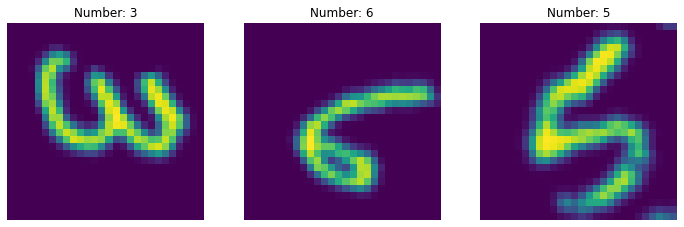

In [73]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# transform only a sample of the data
(x_small, y_small) = choice((x_train, y_train), 10000)

# normalise training data
x_train = normalise(x_train)
x_small = normalise(x_small)
x_test = normalise(x_test)

print_dataset_summary("x_small", x_small)
print_dataset_summary("x_train", x_train)
print_dataset_summary("y_train", y_train)
print_dataset_summary("x_test", x_test)

# augment data
# (x_augmented, y_augmented) = augment((x_small, y_small))
(x_augmented, y_augmented) = augment((x_train, y_train))
print_dataset_summary("x_augmented", x_augmented)
print_dataset_summary("y_augmented", y_augmented)
view_images(choice((x_augmented, y_augmented), 3), (12, 12))

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

assert y_train.shape[0] == x_train.shape[0]

In [76]:
batch_size = 128
epochs = 5

model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

# model.summary()

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/5
422/422 [==============================] - 7s 16ms/step - loss: 0.7520 - accuracy: 0.7666 - val_loss: 0.0843 - val_accuracy: 0.9770
Epoch 2/5
422/422 [==============================] - 7s 16ms/step - loss: 0.1219 - accuracy: 0.9624 - val_loss: 0.0606 - val_accuracy: 0.9830
Epoch 3/5
422/422 [==============================] - 7s 16ms/step - loss: 0.0869 - accuracy: 0.9733 - val_loss: 0.0483 - val_accuracy: 0.9867
Epoch 4/5
422/422 [==============================] - 7s 15ms/step - loss: 0.0779 - accuracy: 0.9754 - val_loss: 0.0455 - val_accuracy: 0.9873
Epoch 5/5
422/422 [==============================] - 7s 15ms/step - loss: 0.0608 - accuracy: 0.9811 - val_loss: 0.0391 - val_accuracy: 0.9892


In [77]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.03464192524552345
Test accuracy: 0.9887999892234802
